# GIZ NLP Agricultural Keyword Spotter

File name: GIZNLP_Modelling.ipynb

Author: kogni7

Date: October/November 2020

## Contents
* 1 Preparation
  * 1.1 Libraries and Seed
  * 1.2 Variables
* 2 Data
* 3 Model
* 4 Train Algorithm
* 5 Submission
  * 5.1 Training
  * 5.2 Prediction
  * 5.3 Saving

At first, run the preprocessing notebook!

This notebook uses only the data sets provided by ZINDI. These data sets contain wav-files which are vocal utterances in English and Luganda. The (processed) utterances are the only used features in this notebook.

The file system for this project is:

- GIZNLP (root)
  - GIZNLP_Preprocessing.ipynb
  - GIZNLP_Modelling.ipynb (this notebook)
  - Data
      - audio_files
      - latest_keywords
      - nlp_keywords
      - Train.csv
      - SampleSubmission.csv
  - Preprocessed_Data (will be created during the run of the preprocessing notebook)
  - Submission
      - 1 - x: Submission directories, named by the version number
          - checkpoint_model.h5 (saved keras model)
          - model.h5 (saved keras model)
          - submission.csv

This jupyter notebook runs in Google Colab without special configuration (and with the automatically loaded packages).

The GPU is enabled for hardware acceleration. The results are probably not exactly reproducible, but the differences should be small.

This notebook uses some basic ideas from the starter notebook.

The idea of the notebook is a deep learning based approach.

## 1. Preparation
### 1.1 Libraries and Seed

In [1]:
SEED = 42

# Math
import numpy as np

# Tensorflow
import tensorflow as tf

# Seeds
import random
import os
os.environ['PYTHONHASHSEED'] = str(SEED)

np.random.seed(SEED + 1)
random.seed(SEED + 2)

tf.random.set_seed(SEED + 3)

# Working with CSV
import pandas as pd

# Further imports
import time
import pickle

# Plotting
import matplotlib.pyplot as plt

# Deep learning
from keras.models import Model
from keras.layers import AveragePooling2D, BatchNormalization, Conv2D, Dense, Dropout, GlobalAveragePooling2D, Input, MaxPooling2D, ReLU, SpatialDropout2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.constraints import max_norm

### 1.2 Variables

In [2]:
# Time 
start_time = time.time()

# The Version
VERSION = 'test_c'

# for use in Google Colab
from google.colab import drive
drive.mount('/content/drive')

# Working Directory
WD = os.getcwd() + "/drive/My Drive/Colab Notebooks/GIZNLP"
print(WD)

# Classes
CLASSES = 193

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/GIZNLP


## 2 Data

In [3]:
# The preprocessed data
with open(WD + '/Preprocessed_Data/X.dat', 'rb') as file:
    X = pickle.load(file)

with open(WD + '/Preprocessed_Data/y.dat', 'rb') as file:
    y = pickle.load(file)

with open(WD + '/Preprocessed_Data/X_val.dat', 'rb') as file:
    X_val = pickle.load(file)

with open(WD + '/Preprocessed_Data/y_val.dat', 'rb') as file:
    y_val = pickle.load(file)

with open(WD + '/Preprocessed_Data/X_test.dat', 'rb') as file:
    X_test = pickle.load(file)

# The original sample submission
sample_submission = pd.read_csv(WD + '/Data/SampleSubmission.csv')
sample_submission_fn = sample_submission.fn
sample_submission_index = sample_submission.index
sample_submission_columns = sample_submission.columns
del sample_submission

## 3 Model

In [4]:
def get_model(parameters):
    """
    The model using deep learning.
    """

    input = Input(shape=(None, None, 1))

    layer = input

    for letter in parameters["Structure"]:

        # Conv
        if letter == "C":
            layer = Conv2D(parameters["filters"][0], parameters["kernel_size"][0],
                           kernel_constraint=parameters["Conv_constraint"],
                           bias_constraint=parameters["Conv_constraint"],
                           data_format='channels_last')(layer)
            parameters["filters"].pop(0)
            parameters["kernel_size"].pop(0)

        # Dense
        if letter == "D":
            layer = Dense(parameters["Dense_units"][0],
                          kernel_constraint=parameters["Dense_constraint"],
                          bias_constraint=parameters["Dense_constraint"])(layer)
            parameters["Dense_units"].pop(0)

        # MaxPooling
        if letter == "M":
            layer = MaxPooling2D(pool_size=parameters["pool_size"][0])(layer)
            parameters["pool_size"].pop(0)

        # AveragePooling
        if letter == "A":
            layer = AveragePooling2D(pool_size=parameters["pool_size"][0])(layer)
            parameters["pool_size"].pop(0)

        # GlobalAveragePooling
        if letter == "G": layer = GlobalAveragePooling2D()(layer)

        # ReLU
        if letter == "R": layer = ReLU()(layer)

        # Dropout
        if letter == "O":
            layer = Dropout(parameters["rate"][0], seed=SEED)(layer)  
            parameters["rate"].pop(0)

        # SpatialDropout
        if letter == "S":
            layer = SpatialDropout2D(parameters["spatial_rate"][0])(layer)
            parameters["spatial_rate"].pop(0)

        # BatchNormalization
        if letter == "N": layer = BatchNormalization()(layer)

    # OUPUT
    output = Dense(CLASSES, activation='sigmoid')(layer)

    model = Model(inputs=input, outputs=output)

    # Model run
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=parameters['lr']))

    return model

## 4 Train Algorithm

In [5]:
def training(X, y, X_val, y_val, parameters):
    """
    This function is the procedure of a training, i.e. 80% of data for training and 20% for validation.
    """

    print("Training is starting...")

    # Model
    print("\nModel building...")
    model = get_model(parameters)
    model.summary()

    # Modelcheckpoint
    modelcheckpoint = ModelCheckpoint(filepath=WD + '/Submission/' + str(VERSION) + '/checkpoint_model.h5',
                                      save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)

    # Early Stopping
    earlystopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

    # Fit
    print("\nFitting...")
    model_fit=model.fit(X, y,
                        batch_size=parameters["batch_size"],
                        epochs=parameters["epochs"],
                        verbose=1,
                        validation_data=(X_val, y_val),
                        callbacks=[modelcheckpoint, earlystopping])

    model.load_weights(WD + '/Submission/' + str(VERSION) + '/checkpoint_model.h5')

    # Minima
    val_loss = np.min(model_fit.history['val_loss'])
    epoch = model_fit.history['val_loss'].index(val_loss)
    train_loss = model_fit.history['loss'][epoch]

    print("Best epoch: {}; TRAIN loss: {:.4f}, VAL loss: {:.4f}".format(epoch, train_loss, val_loss))

    # Plot
    plot_df = pd.DataFrame(model_fit.history)
    plot_df.loc[:, ['loss', 'val_loss']].plot()

    return model

## 5 Submission
### 5.1 Training

Training is starting...

Model building...
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1664      
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, None, None, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, None, None, 64)    256       
_________________________________________________________________
re_lu (ReLU)                 (None, None, None, 64)    0         
_________________________________________________________________
average_pooling2d (AveragePo (None, None, None, 64)    0         
_________________________________________________________________
conv2d_1 (C

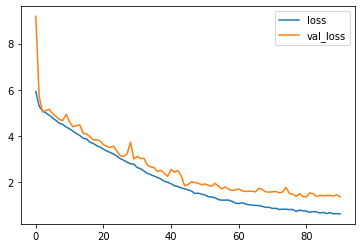

In [6]:
parameters = {}

"""
Define the net structure with the following notation:
1   Conv2D                  C
2   Dense                   D
3   MaxPooling              M
4   AveragePooling          A
5   GlobalAveragePooling    G
6   ReLU                    R
7   Dropout                 O
8   SpatialDropout          S
9   BatchNormalization      N
"""

parameters["Structure"] = 'C' + 'S' + 'N' + 'R' + 'A' + \
                          'C' + 'S' + 'N' + 'R' + 'A' + \
                          'C' + 'S' + 'N' + 'R' + 'G' + \
                          'D' + 'O' + 'N' + 'R' + \
                          'D' + 'O' + 'N' + 'R' + \
                          'D' + 'O' + 'N' + 'R'

# Conv2D
parameters["filters"] = [64, 128, 256]
parameters["kernel_size"] = [(5, 5), (5, 5), (5, 5)]
parameters["Conv_constraint"] = None

# Pooling
parameters["pool_size"] = [(3, 3), (3, 3)]

# Dense
parameters["Dense_units"] = [2000, 1000, 500]
parameters["Dense_constraint"] = None

# Dropout
parameters["rate"] = [0.25, 0.25, 0.25]

# SpatialDropout
parameters["spatial_rate"] = [0.15, 0.15, 0.15]

# General
parameters["lr"] = 0.01
parameters["epochs"] = 100
parameters["batch_size"] = 50

model = training(X, y, X_val, y_val, parameters)

### 5.2 Prediction

In [7]:
prediction = model.predict(X_test)

### 5.3 Saving

In [8]:
model.save(WD + '/Submission/' + str(VERSION) + '/model.h5')

output = pd.DataFrame(prediction, index=sample_submission_index, columns=sample_submission_columns[1:])
output['fn'] = sample_submission_fn
output = output[sample_submission_columns]

output.to_csv(WD + '/Submission/' + str(VERSION) + '/submission.csv', index=False)

print("Saved.")

Saved.


In [9]:
drive.flush_and_unmount()
end_time = time.time()
print("Everything done.\nDuration of the notebook was {:.2f} seconds.".format(end_time - start_time))

Everything done.
Duration of the notebook was 972.79 seconds.
